In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
print("bluetooth\n", df_bt.head())

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
print("\ncalls\n", df_calls.head())

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())

df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
print("\ngenders\n", df_genders.head())

bluetooth
    # timestamp  user_a  user_b  rssi
0            0       0      -1     0
1            0       1      -1     0
2            0       2      -1     0
3            0       3      -2   -88
4            0       5      -1     0

calls
    timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5

sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136

facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
    # user  female
0       0       0
1       2       0
2       3       0
3       4       0
4       5       0


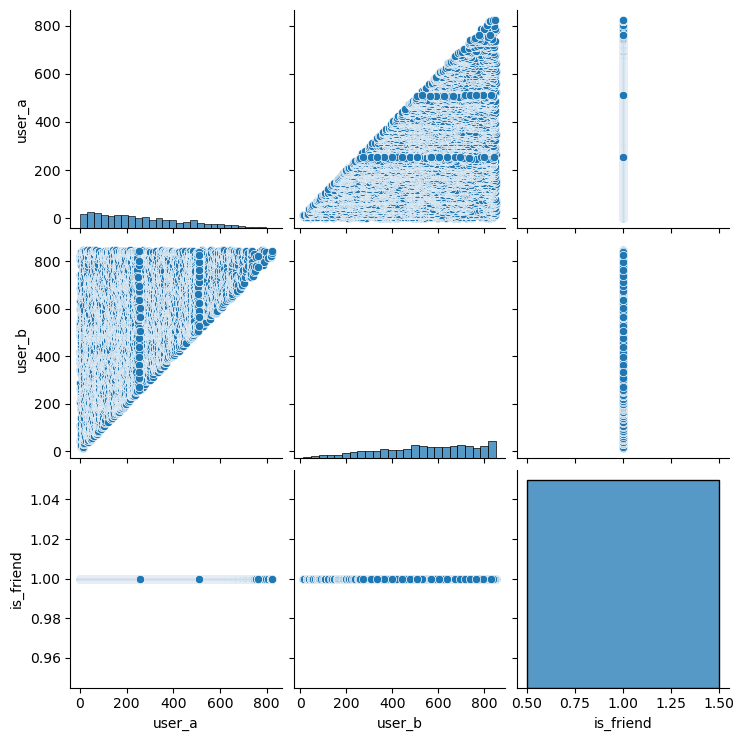

In [73]:
sns.pairplot(df_facebook_friends)
plt.show()

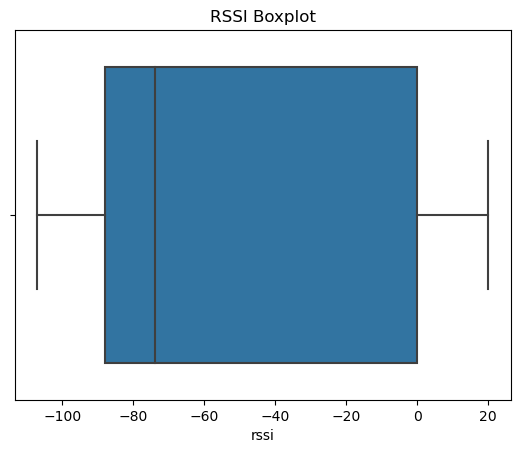

In [5]:
sns.boxplot(x=df_bt['rssi'])
plt.title('RSSI Boxplot')

plt.show()

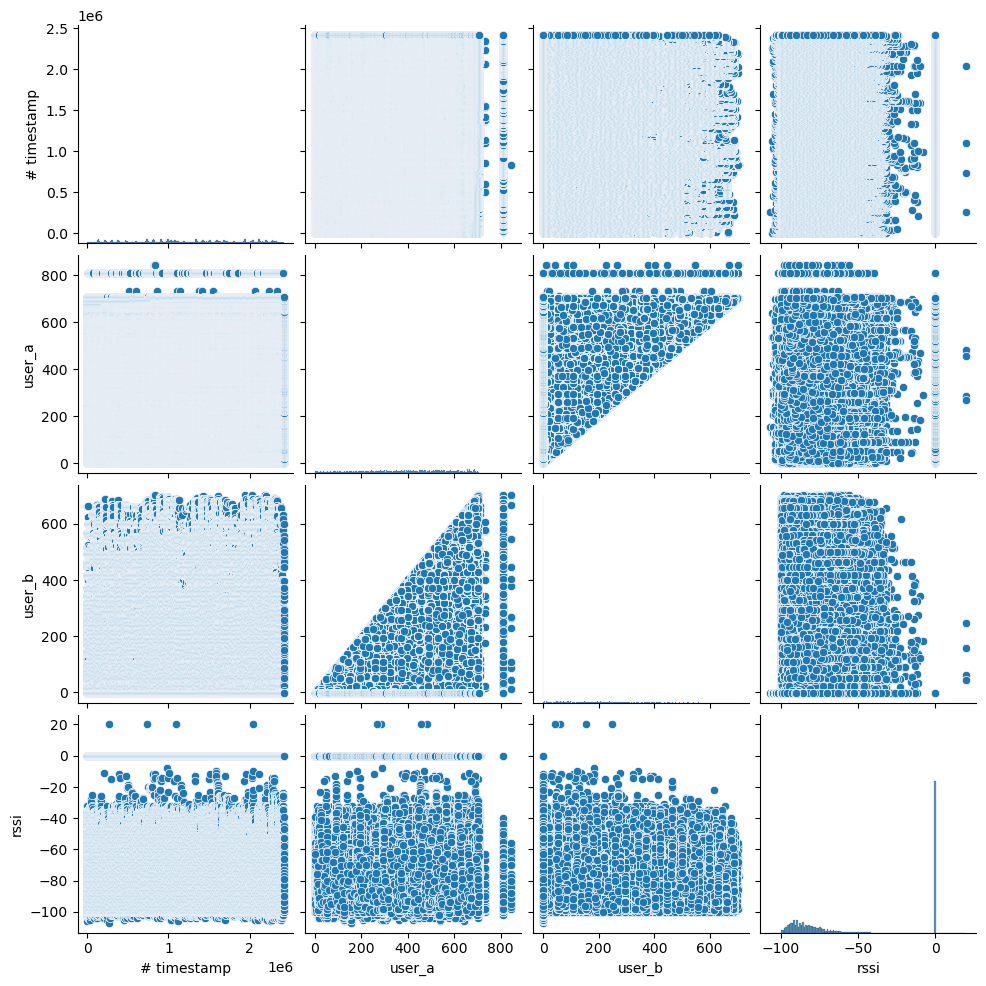

In [6]:
sns.pairplot(df_bt)
plt.show()

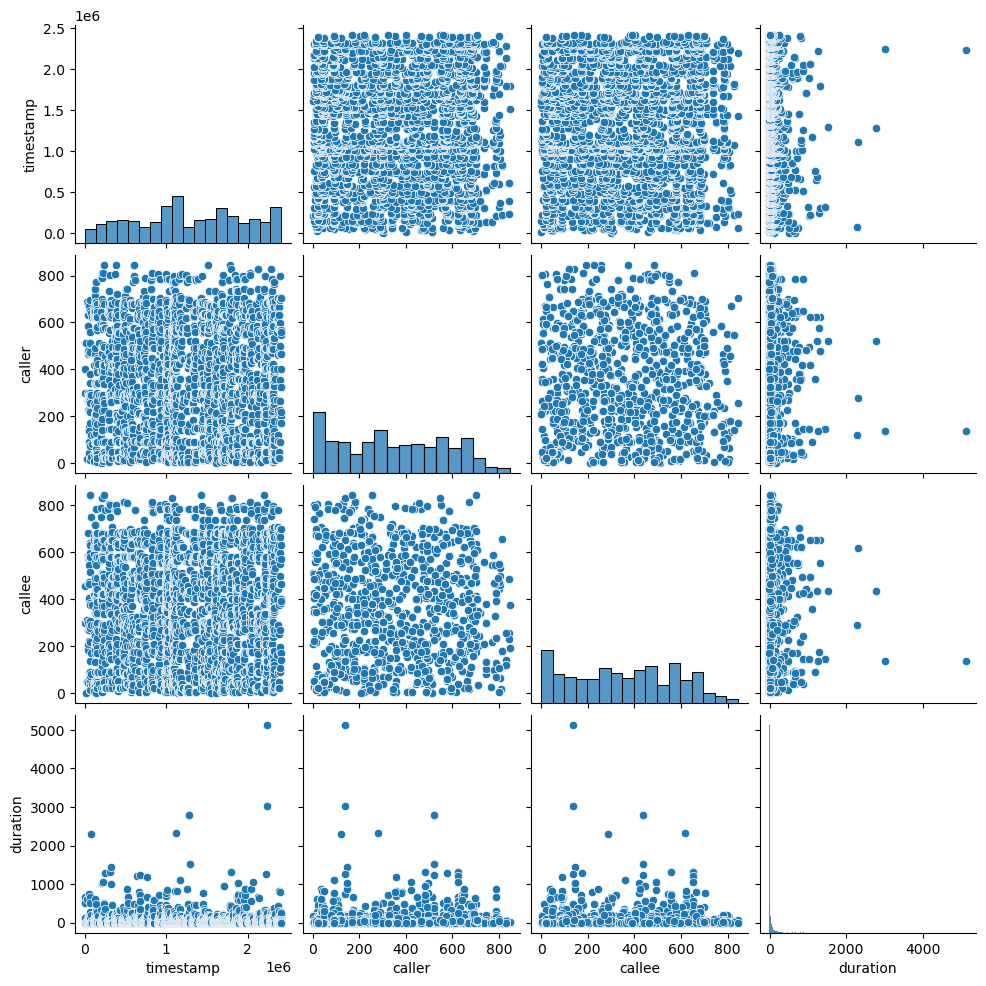

In [48]:
sns.pairplot(df_calls)
plt.show()

In [5]:
# 检查是否有重复的行
print(df_bt.duplicated().sum())

0


In [6]:
# 检查各数据集中是否有缺失值
print(df_bt.isnull().sum())        # 蓝牙数据
print(df_calls.isnull().sum())     # 通话数据
print(df_sms.isnull().sum())       # 短信数据
print(df_facebook_friends.isnull().sum())  # Facebook好友数据
print(df_genders.isnull().sum())   # 性别数据

# timestamp    0
user_a         0
user_b         0
rssi           0
dtype: int64
timestamp    0
caller       0
callee       0
duration     0
dtype: int64
timestamp    0
sender       0
recipient    0
dtype: int64
# user_a    0
user_b      0
dtype: int64
# user    0
female    0
dtype: int64


In [7]:
print(df_bt.shape[0])
df_bt

5474289


,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0
...,...,...,...,...
5474284,2418900,702,371,-79
5474285,2418900,703,-1,0
5474286,2418900,704,-1,0
5474287,2418900,705,-2,-90


In [8]:
# empty scan are marked with user B = -1 and RSSI = 0

cleaned_df_bt = df_bt[(df_bt['user_b'] != -1) & (df_bt['user_b'] != -2) & (df_bt['rssi'] < 0)]
print(cleaned_df_bt.shape[0])
cleaned_df_bt

2426275


,# timestamp,user_a,user_b,rssi
15,0,21,20,-73
34,0,47,19,-86
36,0,49,48,-62
51,0,69,44,-87
66,0,90,64,-96
...,...,...,...,...
5474280,2418900,702,194,-83
5474281,2418900,702,259,-58
5474282,2418900,702,294,-94
5474283,2418900,702,359,-94


In [9]:
print(df_calls.shape[0])
df_calls

3600


,timestamp,caller,callee,duration
0,184,300,301,121
1,3920,512,299,670
2,5623,301,300,504
3,9252,401,457,-1
4,15466,512,0,5
...,...,...,...,...
3595,2414934,706,401,78
3596,2415585,218,382,48
3597,2416059,561,631,13
3598,2416368,323,392,4


In [10]:
# duration (-1 means a missed call)
# we focus on interactions that actually took place
cleaned_df_calls = df_calls[df_calls['duration'] > 0]
cleaned_df_calls
print(cleaned_df_calls.shape[0])

2654


In [11]:
# duration (-1 means a missed call)
# we focus on interactions that actually took place
cleaned_df_calls_1 = df_calls[df_calls['duration'] >= 0]
cleaned_df_calls_1
print(cleaned_df_calls_1.shape[0])

3234


In [12]:
df_sms_fil1 = df_sms[df_sms.sender == df_sms.recipient]
df_sms_fil1

,timestamp,sender,recipient


In [13]:
cleaned_df_sms = df_sms

In [14]:
# 创建二元特征，表示是否是Facebook好友
df_facebook_friends['is_friend'] = 1
df_facebook_friends

,# user_a,user_b,is_friend
0,0,512,1
1,0,263,1
2,0,525,1
3,0,285,1
4,0,543,1
...,...,...,...
6424,510,737,1
6425,510,763,1
6426,255,566,1
6427,255,605,1


In [15]:
# 确保 df_calls 是一个独立的副本
cleaned_df_calls = cleaned_df_calls.copy()
cleaned_df_bt = cleaned_df_bt.copy()
cleaned_df_sms = cleaned_df_sms.copy()

# 检查 timestamp 列的数据类型，确保它是以秒为单位的相对时间戳
print(cleaned_df_calls['timestamp'].dtype)

# 如果 timestamp 是相对时间戳（单位为秒），则设置起始时间
start_date = pd.to_datetime('2023-01-01')

# 将相对时间戳转换为从2023年1月1日开始的具体日期
cleaned_df_calls['timestamp'] = start_date + pd.to_timedelta(cleaned_df_calls['timestamp'], unit='s')
cleaned_df_bt['# timestamp'] = start_date + pd.to_timedelta(cleaned_df_bt['# timestamp'], unit='s')
cleaned_df_sms['timestamp'] = start_date + pd.to_timedelta(cleaned_df_sms['timestamp'], unit='s')

# 查看转换后的结果
print(cleaned_df_calls[['timestamp']])
print(cleaned_df_bt[['# timestamp']])
print(cleaned_df_sms[['timestamp']])


int64
               timestamp
0    2023-01-01 00:03:04
1    2023-01-01 01:05:20
2    2023-01-01 01:33:43
4    2023-01-01 04:17:46
5    2023-01-01 04:18:17
...                  ...
3595 2023-01-28 22:48:54
3596 2023-01-28 22:59:45
3597 2023-01-28 23:07:39
3598 2023-01-28 23:12:48
3599 2023-01-28 23:13:19

[2654 rows x 1 columns]
                # timestamp
15      2023-01-01 00:00:00
34      2023-01-01 00:00:00
36      2023-01-01 00:00:00
51      2023-01-01 00:00:00
66      2023-01-01 00:00:00
...                     ...
5474280 2023-01-28 23:55:00
5474281 2023-01-28 23:55:00
5474282 2023-01-28 23:55:00
5474283 2023-01-28 23:55:00
5474284 2023-01-28 23:55:00

[2426275 rows x 1 columns]
                timestamp
0     2023-01-01 00:00:18
1     2023-01-01 00:00:37
2     2023-01-01 00:02:06
3     2023-01-01 00:02:14
4     2023-01-01 00:05:12
...                   ...
24328 2023-01-28 22:53:18
24329 2023-01-28 23:13:33
24330 2023-01-28 23:27:18
24331 2023-01-28 23:33:53
24332 2023-01-28 23

In [16]:
# set RSSI > -70
RSSI_THRESHOLD = -70

df_bt_nearby = cleaned_df_bt[cleaned_df_bt['rssi'] > RSSI_THRESHOLD]

df_bt_nearby

,# timestamp,user_a,user_b,rssi
36,2023-01-01 00:00:00,49,48,-62
67,2023-01-01 00:00:00,91,90,-60
207,2023-01-01 00:00:00,288,104,-51
310,2023-01-01 00:00:00,421,414,-68
342,2023-01-01 00:00:00,459,260,-38
...,...,...,...,...
5474180,2023-01-28 23:55:00,549,161,-66
5474197,2023-01-28 23:55:00,569,465,-58
5474237,2023-01-28 23:55:00,635,542,-52
5474272,2023-01-28 23:55:00,694,598,-66


In [17]:
df_bt_nearby[(df_bt_nearby['user_a'] == 5) & (df_bt_nearby['user_b'] == 4)]


,# timestamp,user_a,user_b,rssi
4113724,2023-01-21 21:35:00,5,4,-62


In [18]:
df_bt[(df_bt['user_a'] == 5) & (df_bt['user_b'] == 4)]

,# timestamp,user_a,user_b,rssi
3089741,1356000,5,4,-96
3764701,1633200,5,4,-93
3765219,1633500,5,4,-92
3765748,1633800,5,4,-96
3766272,1634100,5,4,-88
...,...,...,...,...
4140021,1818600,5,4,-90
4140619,1818900,5,4,-89
4141786,1819500,5,4,-97
4142396,1819800,5,4,-95


In [19]:
print(df_calls['timestamp'].head())  # 检查实际的时间戳值

0      184
1     3920
2     5623
3     9252
4    15466
Name: timestamp, dtype: int64


In [20]:
# 假设 df_bt_nearby 是你的输入数据框，'# timestamp' 列是 datetime 类型

# 设置时间差阈值为5分钟
time_diff_threshold = pd.Timedelta(seconds=300)  # 5分钟的时间差

# 按用户对和日期分组，并对每组数据按时间戳排序
df_bt_nearby_sorted = df_bt_nearby.sort_values(by=['user_a', 'user_b', '# timestamp'])

# 计算每对用户的时间差
df_bt_nearby_sorted['time_diff'] = df_bt_nearby_sorted.groupby(['user_a', 'user_b'])['# timestamp'].diff()

# 标记每个接近事件，判断是否为新的接近事件
df_bt_nearby_sorted['new_proximity'] = (df_bt_nearby_sorted['time_diff'].isna()) | (df_bt_nearby_sorted['time_diff'] > time_diff_threshold)

# 为每对用户分配 event_id，确保唯一性
df_bt_nearby_sorted['event_id'] = df_bt_nearby_sorted.groupby(['user_a', 'user_b'])['new_proximity'].cumsum()

# 计算每个接近事件的开始和结束时间
event_start_times = df_bt_nearby_sorted.groupby(['user_a', 'user_b', 'event_id'])['# timestamp'].first().reset_index()
event_end_times = df_bt_nearby_sorted.groupby(['user_a', 'user_b', 'event_id'])['# timestamp'].last().reset_index()

# 合并开始和结束时间
proximity_events = pd.merge(event_start_times, event_end_times, on=['user_a', 'user_b', 'event_id'], suffixes=('_start', '_end'))

# 计算每个接近事件的持续时间
proximity_events['proximity_duration'] = (proximity_events['# timestamp_end'] - proximity_events['# timestamp_start']).dt.total_seconds()

# 将 proximity_duration 列中所有为 0 的值更新为 2.5
proximity_events['proximity_duration'] = proximity_events['proximity_duration'].replace(0, 2.5)

# 计算每对用户的接近频率（事件数量）
df_bt_proximity_duration = proximity_events[['user_a', 'user_b', '# timestamp_start', 'proximity_duration']].copy()

### 计算每日接近频率和总持续时间 (daily_freq with duration) ###
# 提取日期并统计每对用户每天的接近次数和持续时间
df_bt_proximity_duration['date'] = pd.to_datetime(df_bt_proximity_duration['# timestamp_start']).dt.date
bt_freq_daily = df_bt_proximity_duration.groupby(['user_a', 'user_b', 'date']).agg(
    daily_freq_proximity=('proximity_duration', 'size'),  # 每日接近次数
    daily_duration_proximity=('proximity_duration', 'sum')  # 每日总持续时间
).reset_index()

### 计算每周接近频率和总持续时间 (weekly_freq wformalizaith duration) ###
# 提取周并统计每对用户每周的接近次数和持续时间
df_bt_proximity_duration['week'] = pd.to_datetime(df_bt_proximity_duration['# timestamp_start']).dt.to_period('W-SAT').apply(lambda r: r.start_time)
bt_freq_weekly= df_bt_proximity_duration.groupby(['user_a', 'user_b', 'week']).agg(
    weekly_freq_proximity=('proximity_duration', 'size'),  # 每周接近次数
    weekly_duration_proximity=('proximity_duration', 'sum')  # 每周总持续时间
).reset_index()

# 汇总每对用户的接近频率和总持续时间
bt_summary = df_bt_proximity_duration.groupby(['user_a', 'user_b']).agg(
    total_proximity_count=('proximity_duration', 'size') , # 事件数量即为接近次数
    total_proximity_duration=('proximity_duration', 'sum')
).reset_index()

# ### 计算每日接近频率 (daily_freq) ###
# # 提取日期并统计每对用户每天的接近次数
# df_bt_proximity_duration['date'] = pd.to_datetime(df_bt_proximity_duration['# timestamp_start']).dt.date
# daily_freq = df_bt_proximity_duration.groupby(['user_a', 'user_b', 'date']).size().reset_index(name='daily_freq')

# ### 计算每周接近频率 (weekly_freq) ###
# # 提取周并统计每对用户每周的接近次数
# df_bt_proximity_duration['week'] = pd.to_datetime(df_bt_proximity_duration['# timestamp_start']).dt.to_period('W-SAT').apply(lambda r: r.start_time)
# weekly_freq = df_bt_proximity_duration.groupby(['user_a', 'user_b', 'week']).size().reset_index(name='weekly_freq')

# 打印结果
print(bt_summary.head(20))  # 总接近次数和持续时间



    user_a  user_b  total_proximity_count  total_proximity_duration
0        5       4                      1                       2.5
1       12      11                      3                       7.5
2       13       5                      2                       5.0
3       13       6                      1                       2.5
4       13      11                      7                     915.0
5       13      12                    148                   45537.5
6       14       4                      2                       5.0
7       15      13                      1                     300.0
8       21      20                    197                   80057.5
9       22      13                      1                       2.5
10      23       1                      1                       2.5
11      25       0                      3                       7.5
12      25       3                      1                       2.5
13      25      12                     70       

In [21]:
print(bt_freq_daily.head(20))  # 每日接近频率

    user_a  user_b        date  daily_freq_proximity  daily_duration_proximity
0        5       4  2023-01-21                     1                       2.5
1       12      11  2023-01-21                     1                       2.5
2       12      11  2023-01-24                     2                       5.0
3       13       5  2023-01-18                     2                       5.0
4       13       6  2023-01-26                     1                       2.5
5       13      11  2023-01-02                     1                       2.5
6       13      11  2023-01-04                     1                       2.5
7       13      11  2023-01-12                     1                       2.5
8       13      11  2023-01-17                     1                     900.0
9       13      11  2023-01-18                     1                       2.5
10      13      11  2023-01-19                     1                       2.5
11      13      11  2023-01-21                     1

In [22]:
print(bt_freq_weekly.head(10))  # 每周接近频率

   user_a  user_b       week  weekly_freq_proximity  weekly_duration_proximity
0       5       4 2023-01-15                      1                        2.5
1      12      11 2023-01-15                      1                        2.5
2      12      11 2023-01-22                      2                        5.0
3      13       5 2023-01-15                      2                        5.0
4      13       6 2023-01-22                      1                        2.5
5      13      11 2023-01-01                      2                        5.0
6      13      11 2023-01-08                      1                        2.5
7      13      11 2023-01-15                      4                      907.5
8      13      12 2023-01-01                     20                     5125.0
9      13      12 2023-01-08                     50                    24665.0


In [23]:
print(df_bt_nearby_sorted.head(20))

                # timestamp  user_a  user_b  rssi       time_diff  \
4113724 2023-01-21 21:35:00       5       4   -62             NaT   
4045327 2023-01-21 10:50:00      12      11   -68             NaT   
4517192 2023-01-24 01:20:00      12      11   -64 2 days 14:30:00   
4627954 2023-01-24 13:30:00      12      11   -65 0 days 12:10:00   
3413963 2023-01-18 08:10:00      13       5   -66             NaT   
3420915 2023-01-18 08:40:00      13       5   -64 0 days 00:30:00   
5038973 2023-01-26 11:45:00      13       6   -68             NaT   
175724  2023-01-02 06:50:00      13      11   -62             NaT   
566185  2023-01-04 05:50:00      13      11   -68 1 days 23:00:00   
2161847 2023-01-12 09:15:00      13      11   -43 8 days 03:25:00   
3321863 2023-01-17 19:05:00      13      11   -57 5 days 09:50:00   
3322403 2023-01-17 19:10:00      13      11   -65 0 days 00:05:00   
3322935 2023-01-17 19:15:00      13      11   -59 0 days 00:05:00   
3323471 2023-01-17 19:20:00      1

In [24]:
print(proximity_events.head(20))

    user_a  user_b  event_id   # timestamp_start     # timestamp_end  \
0        5       4         1 2023-01-21 21:35:00 2023-01-21 21:35:00   
1       12      11         1 2023-01-21 10:50:00 2023-01-21 10:50:00   
2       12      11         2 2023-01-24 01:20:00 2023-01-24 01:20:00   
3       12      11         3 2023-01-24 13:30:00 2023-01-24 13:30:00   
4       13       5         1 2023-01-18 08:10:00 2023-01-18 08:10:00   
5       13       5         2 2023-01-18 08:40:00 2023-01-18 08:40:00   
6       13       6         1 2023-01-26 11:45:00 2023-01-26 11:45:00   
7       13      11         1 2023-01-02 06:50:00 2023-01-02 06:50:00   
8       13      11         2 2023-01-04 05:50:00 2023-01-04 05:50:00   
9       13      11         3 2023-01-12 09:15:00 2023-01-12 09:15:00   
10      13      11         4 2023-01-17 19:05:00 2023-01-17 19:20:00   
11      13      11         5 2023-01-18 02:10:00 2023-01-18 02:10:00   
12      13      11         6 2023-01-19 00:05:00 2023-01-19 00:0

In [25]:
# 创建 week 映射，将具体日期映射为 'week 1', 'week 2', 等等
week_mapping = {
    pd.Timestamp('2023-01-01'): 'week 1',
    pd.Timestamp('2023-01-08'): 'week 2',
    pd.Timestamp('2023-01-15'): 'week 3',
    pd.Timestamp('2023-01-22'): 'week 4'
}

# 使用 map() 函数将 week 列映射到新的 week 编号
bt_freq_weekly['week'] = bt_freq_weekly['week'].map(week_mapping)

# 查看更新后的 weekly_freq 数据
print(bt_freq_weekly.head(20))


    user_a  user_b    week  weekly_freq_proximity  weekly_duration_proximity
0        5       4  week 3                      1                        2.5
1       12      11  week 3                      1                        2.5
2       12      11  week 4                      2                        5.0
3       13       5  week 3                      2                        5.0
4       13       6  week 4                      1                        2.5
5       13      11  week 1                      2                        5.0
6       13      11  week 2                      1                        2.5
7       13      11  week 3                      4                      907.5
8       13      12  week 1                     20                     5125.0
9       13      12  week 2                     50                    24665.0
10      13      12  week 3                     35                     6970.0
11      13      12  week 4                     43                     8777.5

In [28]:
print(cleaned_df_calls['timestamp'].head())  # 检查实际的时间戳值

0   2023-01-01 00:03:04
1   2023-01-01 01:05:20
2   2023-01-01 01:33:43
4   2023-01-01 04:17:46
5   2023-01-01 04:18:17
Name: timestamp, dtype: datetime64[ns]


In [27]:
cleaned_df_calls

,timestamp,caller,callee,duration
0,2023-01-01 00:03:04,300,301,121
1,2023-01-01 01:05:20,512,299,670
2,2023-01-01 01:33:43,301,300,504
4,2023-01-01 04:17:46,512,0,5
5,2023-01-01 04:18:17,512,0,28
...,...,...,...,...
3595,2023-01-28 22:48:54,706,401,78
3596,2023-01-28 22:59:45,218,382,48
3597,2023-01-28 23:07:39,561,631,13
3598,2023-01-28 23:12:48,323,392,4


In [27]:
# cleaned_df_calls['date'] = pd.to_datetime(cleaned_df_calls['timestamp'], unit='s').dt.date
# call_freq_daily = cleaned_df_calls.groupby(['caller', 'callee', 'date']).size().reset_index(name='daily_freq')
# call_freq_daily_sorted = call_freq_daily.sort_values(by=['caller', 'callee'])

# # 创建每周的起始日期，从周日开始
# cleaned_df_calls['week'] = cleaned_df_calls['timestamp'].dt.to_period('W-SAT').apply(lambda r: r.start_time)

# # 计算每对用户每周的通话频率
# call_freq_weekly = cleaned_df_calls.groupby(['caller', 'callee', 'week']).size().reset_index(name='call_freq')

# # 按照 caller 和 callee 排序
# call_freq_weekly_sorted = call_freq_weekly.sort_values(by=['caller', 'callee'])

# # 查看结果
# print(call_freq_daily_sorted)
# print(call_freq_weekly_sorted)

# # # 查看结果
# # print(call_freq_weekly)

      caller  callee        date  daily_freq
0          0     208  2023-01-19           2
1          0     512  2023-01-03           1
2          3      48  2023-01-13           1
3          3      49  2023-01-13           1
4          3      49  2023-01-22           2
...      ...     ...         ...         ...
1787     830     257  2023-01-25           1
1788     845     228  2023-01-05           1
1789     845     256  2023-01-03           1
1790     846     191  2023-01-21           1
1791     846     374  2023-01-18           1

[1792 rows x 4 columns]
      caller  callee       week  call_freq
0          0     208 2023-01-15          2
1          0     512 2023-01-01          1
2          3      48 2023-01-08          1
3          3      49 2023-01-08          1
4          3      49 2023-01-22          2
...      ...     ...        ...        ...
1275     830     257 2023-01-22          1
1276     845     228 2023-01-01          1
1277     845     256 2023-01-01          1
1278 

In [31]:
# # 将时间戳转换为日期
# cleaned_df_calls['date'] = pd.to_datetime(cleaned_df_calls['timestamp'], unit='s').dt.date

# # 计算每日通话频率
# call_freq_daily = cleaned_df_calls.groupby(['caller', 'callee', 'date']).size().reset_index(name='daily_freq')

# # 计算每日通话时长
# daily_total_duration = cleaned_df_calls.groupby(['caller', 'callee', 'date'])['duration'].sum().reset_index(name='daily_total_duration')

# # 合并每日通话频率和每日通话时长
# call_freq_daily_sorted = call_freq_daily.merge(daily_total_duration, on=['caller', 'callee', 'date']).sort_values(by=['caller', 'callee'])

# # 创建每周的起始日期，从周日开始
# cleaned_df_calls['week'] = cleaned_df_calls['timestamp'].dt.to_period('W-SAT').apply(lambda r: r.start_time)

# # 计算每对用户每周的通话频率
# call_freq_weekly = cleaned_df_calls.groupby(['caller', 'callee', 'week']).size().reset_index(name='call_freq')

# # 计算每周通话时长
# weekly_total_duration = cleaned_df_calls.groupby(['caller', 'callee', 'week'])['duration'].sum().reset_index(name='weekly_total_duration')

# # 合并每周通话频率和每周通话时长
# call_freq_weekly_sorted = call_freq_weekly.merge(weekly_total_duration, on=['caller', 'callee', 'week']).sort_values(by=['caller', 'callee'])

# # 汇总四周内的通话次数和总通话时长
# call_summary = cleaned_df_calls.groupby(['caller', 'callee']).agg(
#     total_calls=('duration', 'size'),  # 通话次数
#     total_duration=('duration', 'sum')  # 总通话时长
# ).reset_index()

# # 打印结果
# print(call_freq_daily_sorted.head(20))

# print(call_freq_weekly_sorted.head(20))

# print(call_summary.head(20))


    caller  callee        date  daily_freq  daily_total_duration
0        0     208  2023-01-19           2                   180
1        0     512  2023-01-03           1                     3
2        3      48  2023-01-13           1                    34
3        3      49  2023-01-13           1                     2
4        3      49  2023-01-22           2                    23
5        3     357  2023-01-13           1                     4
6        3     357  2023-01-19           1                    36
7        3     357  2023-01-22           1                    32
8        3     357  2023-01-23           1                    32
9        3     485  2023-01-27           1                    20
10       4     221  2023-01-13           2                    13
11       4     221  2023-01-25           1                    49
12       4     266  2023-01-09           1                    42
13       4     266  2023-01-25           1                    59
14       4     266  2023-

In [30]:
# # 使用 map() 函数将 week 列映射到新的 week 编号
# call_freq_weekly_sorted['week'] = call_freq_weekly_sorted['week'].map(week_mapping)

# # 查看更新后的 weekly_freq 数据
# print(call_freq_weekly_sorted.head(20))

    caller  callee    week  call_freq  weekly_total_duration
0        0     208  week 3          2                    180
1        0     512  week 1          1                      3
2        3      48  week 2          1                     34
3        3      49  week 2          1                      2
4        3      49  week 4          2                     23
5        3     357  week 2          1                      4
6        3     357  week 3          1                     36
7        3     357  week 4          2                     64
8        3     485  week 4          1                     20
9        4     221  week 2          2                     13
10       4     221  week 4          1                     49
11       4     266  week 2          1                     42
12       4     266  week 4          2                     66
13       4     344  week 2          1                     11
14       4     344  week 4          1                     13
15       4     424  week

In [33]:
# call_summary[(call_summary['caller'] == 27) & (call_summary['callee'] == 6)]

,caller,callee,total_calls,total_duration
42,27,6,2,105


In [34]:
# call_summary[(call_summary['caller'] == 6) & (call_summary['callee'] == 27)]

,caller,callee,total_calls,total_duration
13,6,27,4,10


In [30]:
# 新建用户对列
cleaned_df_calls['user_a'] = cleaned_df_calls[['caller', 'callee']].max(axis=1)
cleaned_df_calls['user_b'] = cleaned_df_calls[['caller', 'callee']].min(axis=1)

# 计算每日通话频率
cleaned_df_calls['date'] = cleaned_df_calls['timestamp'].dt.date
call_freq_daily = cleaned_df_calls.groupby(['user_a', 'user_b', 'date']).size().reset_index(name='daily_freq_call')

# 计算每日总通话时长
daily_duration = cleaned_df_calls.groupby(['user_a', 'user_b', 'date'])['duration'].sum().reset_index(name='daily_duration_call')
call_freq_daily = pd.merge(call_freq_daily, daily_duration, on=['user_a', 'user_b', 'date'], how='left')

# 创建每周的起始日期，从周日开始
cleaned_df_calls['week'] = cleaned_df_calls['timestamp'].dt.to_period('W-SAT').apply(lambda r: r.start_time)

# 计算每对用户每周的通话频率
call_freq_weekly = cleaned_df_calls.groupby(['user_a', 'user_b', 'week']).size().reset_index(name='weekly_freq_call')

# 计算每对用户每周的总通话时长
weekly_duration = cleaned_df_calls.groupby(['user_a', 'user_b', 'week'])['duration'].sum().reset_index(name='weekly_duration_call')
call_freq_weekly = pd.merge(call_freq_weekly, weekly_duration, on=['user_a', 'user_b', 'week'], how='left')

call_freq_weekly['week'] = call_freq_weekly['week'].map(week_mapping)

# 汇总四周的总通话次数和总通话时长
call_summary = cleaned_df_calls.groupby(['user_a', 'user_b']).agg(
    total_call_count=('duration', 'size'),
    total_call_duration=('duration', 'sum')
).reset_index()

# 打印结果
print(call_freq_daily.head(20))  # 每日通话频率和总时长
print(call_freq_weekly.head(20))  # 每周通话频率和总时长
print(call_summary.head(20))  # 汇总四周的总通话次数和总时长


    user_a  user_b        date  daily_freq_call  daily_duration_call
0       13      11  2023-01-21                1                    2
1       13      12  2023-01-23                2                   56
2       13      12  2023-01-26                1                    2
3       21      20  2023-01-02                1                   18
4       21      20  2023-01-03                6                  520
5       21      20  2023-01-04                3                  513
6       21      20  2023-01-05               11                   71
7       21      20  2023-01-08                1                   18
8       21      20  2023-01-14                5                   13
9       21      20  2023-01-15                6                   87
10      21      20  2023-01-20                2                   75
11      21      20  2023-01-21                1                  169
12      21      20  2023-01-23                1                   42
13      21      20  2023-01-25    

In [31]:
call_summary[(call_summary['user_a'] == 27) & (call_summary['user_b'] == 6)]

,user_a,user_b,total_call_count,total_call_duration
4,27,6,6,115


In [32]:
cleaned_df_sms 

,timestamp,sender,recipient
0,2023-01-01 00:00:18,370,512
1,2023-01-01 00:00:37,512,370
2,2023-01-01 00:02:06,370,512
3,2023-01-01 00:02:14,0,512
4,2023-01-01 00:05:12,137,136
...,...,...,...
24328,2023-01-28 22:53:18,238,26
24329,2023-01-28 23:13:33,137,136
24330,2023-01-28 23:27:18,136,137
24331,2023-01-28 23:33:53,323,392


In [33]:
cleaned_df_sms['user_a'] = cleaned_df_sms[['sender', 'recipient']].max(axis=1)
cleaned_df_sms['user_b'] = cleaned_df_sms[['sender', 'recipient']].min(axis=1)

cleaned_df_sms['date'] = cleaned_df_sms['timestamp'].dt.date
sms_freq_daily = cleaned_df_sms.groupby(['user_a', 'user_b', 'date']).size().reset_index(name='daily_freq_sms')

cleaned_df_sms['week'] = cleaned_df_sms['timestamp'].dt.to_period('W-SAT').apply(lambda r: r.start_time)

sms_freq_weekly = cleaned_df_sms.groupby(['user_a', 'user_b', 'week']).size().reset_index(name='weekly_freq_sms')

sms_freq_weekly['week'] = sms_freq_weekly['week'].map(week_mapping)

sms_summary = cleaned_df_sms.groupby(['user_a', 'user_b']).agg(
    total_sms_count=('user_a', 'size')
).reset_index()

print(sms_freq_daily.head(20))
print(sms_freq_weekly.head(20))
print(sms_summary.head(20))

    user_a  user_b        date  daily_freq_sms
0       13      11  2023-01-21               2
1       13      12  2023-01-03              10
2       13      12  2023-01-06               3
3       13      12  2023-01-21               2
4       13      12  2023-01-22               7
5       13      12  2023-01-24               7
6       13      12  2023-01-26               2
7       21      20  2023-01-01              14
8       21      20  2023-01-02               7
9       21      20  2023-01-03              34
10      21      20  2023-01-04              19
11      21      20  2023-01-05              55
12      21      20  2023-01-06              58
13      21      20  2023-01-07              22
14      21      20  2023-01-08              29
15      21      20  2023-01-09              32
16      21      20  2023-01-10              37
17      21      20  2023-01-11               4
18      21      20  2023-01-12              69
19      21      20  2023-01-13              10
    user_a  u

In [ ]:
# Now we get sms_freq_daily, sms_freq_weekly, sms_summary
#              call_freq_daily, call_freq_weekly, call_summary
#              bt_freq_daily, bt_freq_weekly, bt_summary
#              df_facebook_friends

In [ ]:
# Data Merging

In [34]:
sms_freq_daily

,user_a,user_b,date,daily_freq_sms
0,13,11,2023-01-21,2
1,13,12,2023-01-03,10
2,13,12,2023-01-06,3
3,13,12,2023-01-21,2
4,13,12,2023-01-22,7
...,...,...,...,...
2798,846,291,2023-01-20,1
2799,846,291,2023-01-27,1
2800,846,374,2023-01-18,3
2801,846,437,2023-01-11,2


In [35]:
call_freq_daily

,user_a,user_b,date,daily_freq_call,daily_duration_call
0,13,11,2023-01-21,1,2
1,13,12,2023-01-23,2,56
2,13,12,2023-01-26,1,2
3,21,20,2023-01-02,1,18
4,21,20,2023-01-03,6,520
...,...,...,...,...,...
1446,845,256,2023-01-01,1,55
1447,845,256,2023-01-03,2,65
1448,845,703,2023-01-17,1,67
1449,846,191,2023-01-21,1,23


In [48]:
bt_freq_daily

,user_a,user_b,date,daily_freq,total_daily_duration
0,5,4,2023-01-21,1,2.5
1,12,11,2023-01-21,1,2.5
2,12,11,2023-01-24,2,5.0
3,13,5,2023-01-18,2,5.0
4,13,6,2023-01-26,1,2.5
...,...,...,...,...,...
27892,812,656,2023-01-24,3,1202.5
27893,812,662,2023-01-24,1,2.5
27894,812,673,2023-01-10,6,312.5
27895,845,377,2023-01-10,1,2.5


In [56]:
# 合并短信频率和通话频率数据
merged_daily = sms_freq_daily.merge(call_freq_daily, on=['user_a', 'user_b', 'date'], how='outer', suffixes=('_sms', '_call'))

# 合并蓝牙频率数据
merged_daily = merged_daily.merge(bt_freq_daily, on=['user_a', 'user_b', 'date'], how='outer')

merged_daily.fillna(0, inplace=True)

# 现在，merged_daily 包含了短信、通话和蓝牙频率的每日数据
merged_daily

,user_a,user_b,date,daily_freq_sms,daily_freq_call,daily_duration_call,daily_freq_proximity,daily_duration_proximity
0,13,11,2023-01-21,2.0,1.0,2.0,1.0,2.5
1,13,12,2023-01-03,10.0,0.0,0.0,6.0,610.0
2,13,12,2023-01-06,3.0,0.0,0.0,0.0,0.0
3,13,12,2023-01-21,2.0,0.0,0.0,10.0,3017.5
4,13,12,2023-01-22,7.0,0.0,0.0,5.0,610.0
...,...,...,...,...,...,...,...,...
29958,812,656,2023-01-24,0.0,0.0,0.0,3.0,1202.5
29959,812,662,2023-01-24,0.0,0.0,0.0,1.0,2.5
29960,812,673,2023-01-10,0.0,0.0,0.0,6.0,312.5
29961,845,377,2023-01-10,0.0,0.0,0.0,1.0,2.5


In [57]:
# Data Normalization
# Min-Max
merged_daily_standard = merged_daily.copy()

scaler = StandardScaler()
merged_daily_standard[['standardized_freq_sms', 'standardized_freq_call', 'standardized_duration_call', 'standardized_freq_proximity', 'standardized_duration_proximity']] = scaler.fit_transform(
    merged_daily[['daily_freq_sms', 'daily_freq_call', 'daily_duration_call', 'daily_freq_proximity', 'daily_duration_proximity']]
)

merged_daily_standard

,user_a,user_b,date,daily_freq_sms,daily_freq_call,daily_duration_call,daily_freq_proximity,daily_duration_proximity,standardized_freq_sms,standardized_freq_call,standardized_duration_call,standardized_freq_proximity,standardized_duration_proximity
0,13,11,2023-01-21,2.0,1.0,2.0,1.0,2.5,0.205835,1.810304,-0.053201,-0.501448,-0.325377
1,13,12,2023-01-03,10.0,0.0,0.0,6.0,610.0,1.592046,-0.175933,-0.075205,0.870713,-0.137580
2,13,12,2023-01-06,3.0,0.0,0.0,0.0,0.0,0.379111,-0.175933,-0.075205,-0.775880,-0.326150
3,13,12,2023-01-21,2.0,0.0,0.0,10.0,3017.5,0.205835,-0.175933,-0.075205,1.968441,0.606652
4,13,12,2023-01-22,7.0,0.0,0.0,5.0,610.0,1.072217,-0.175933,-0.075205,0.596280,-0.137580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29958,812,656,2023-01-24,0.0,0.0,0.0,3.0,1202.5,-0.140718,-0.175933,-0.075205,0.047416,0.045580
29959,812,662,2023-01-24,0.0,0.0,0.0,1.0,2.5,-0.140718,-0.175933,-0.075205,-0.501448,-0.325377
29960,812,673,2023-01-10,0.0,0.0,0.0,6.0,312.5,-0.140718,-0.175933,-0.075205,0.870713,-0.229547
29961,845,377,2023-01-10,0.0,0.0,0.0,1.0,2.5,-0.140718,-0.175933,-0.075205,-0.501448,-0.325377


In [58]:
# Data Normalization
# Z-score
merged_daily_minmax = merged_daily.copy()

scaler = MinMaxScaler()
merged_daily_minmax[['normalized_freq_sms', 'normalized_freq_call', 'normalized_duration_call', 'normalized_freq_proximity', 'normalized_duration_proximity']] = scaler.fit_transform(
    merged_daily[['daily_freq_sms', 'daily_freq_call', 'daily_duration_call', 'daily_freq_proximity', 'daily_duration_proximity']]
)

merged_daily_minmax

,user_a,user_b,date,daily_freq_sms,daily_freq_call,daily_duration_call,daily_freq_proximity,daily_duration_proximity,normalized_freq_sms,normalized_freq_call,normalized_duration_call,normalized_freq_proximity,normalized_duration_proximity
0,13,11,2023-01-21,2.0,1.0,2.0,1.0,2.5,0.007143,0.083333,0.000209,0.023256,0.000030
1,13,12,2023-01-03,10.0,0.0,0.0,6.0,610.0,0.035714,0.000000,0.000000,0.139535,0.007286
2,13,12,2023-01-06,3.0,0.0,0.0,0.0,0.0,0.010714,0.000000,0.000000,0.000000,0.000000
3,13,12,2023-01-21,2.0,0.0,0.0,10.0,3017.5,0.007143,0.000000,0.000000,0.232558,0.036041
4,13,12,2023-01-22,7.0,0.0,0.0,5.0,610.0,0.025000,0.000000,0.000000,0.116279,0.007286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29958,812,656,2023-01-24,0.0,0.0,0.0,3.0,1202.5,0.000000,0.000000,0.000000,0.069767,0.014362
29959,812,662,2023-01-24,0.0,0.0,0.0,1.0,2.5,0.000000,0.000000,0.000000,0.023256,0.000030
29960,812,673,2023-01-10,0.0,0.0,0.0,6.0,312.5,0.000000,0.000000,0.000000,0.139535,0.003732
29961,845,377,2023-01-10,0.0,0.0,0.0,1.0,2.5,0.000000,0.000000,0.000000,0.023256,0.000030


In [88]:
df_facebook_friends

,user_a,user_b,is_friend
0,0,512,1
1,0,263,1
2,0,525,1
3,0,285,1
4,0,543,1
...,...,...,...
6424,510,737,1
6425,510,763,1
6426,255,566,1
6427,255,605,1


In [87]:
df_facebook_friends.rename(columns={'# user_a': 'user_a'}, inplace=True)

# 假设 df_facebook_friends 是你的 Facebook 好友关系表
# 交换 user_a 和 user_b 的值，使得 user_a > user_b

# 找出 user_a < user_b 的行，交换 user_a 和 user_b
df_facebook_friends_swapped = df_facebook_friends.copy()
mask = df_facebook_friends_swapped['user_a'] < df_facebook_friends_swapped['user_b']

# 使用 loc 对符合条件的行进行交换
df_facebook_friends_swapped.loc[mask, ['user_a', 'user_b']] = df_facebook_friends_swapped.loc[mask, ['user_b', 'user_a']].values

# 现在，df_facebook_friends_swapped 中的 user_a 都大于 user_b，可以与其他表合并
print(df_facebook_friends_swapped)


      user_a  user_b  is_friend
0        512       0          1
1        263       0          1
2        525       0          1
3        285       0          1
4        543       0          1
...      ...     ...        ...
6424     737     510          1
6425     763     510          1
6426     566     255          1
6427     605     255          1
6428     507     255          1

[6429 rows x 3 columns]


In [110]:
# 合并短信汇总和通话汇总
merged_summary = pd.merge(sms_summary, call_summary, on=['user_a', 'user_b'], how='outer')

# 合并蓝牙接近汇总
merged_summary = pd.merge(merged_summary, bt_summary, on=['user_a', 'user_b'], how='outer')


# 合并 Facebook 好友关系
merged_summary = pd.merge(merged_summary, df_facebook_friends_swapped, on=['user_a', 'user_b'], how='outer')

merged_summary.fillna(0, inplace=True)

# 打印合并后的结果
merged_summary


,user_a,user_b,total_sms_count,total_call_count,total_call_duration,total_proximity_count,total_proximity_duration,is_friend
0,13,11,2.0,1.0,2.0,7.0,915.0,1.0
1,13,12,31.0,3.0,58.0,148.0,45537.5,1.0
2,21,20,788.0,58.0,1962.0,197.0,80057.5,0.0
3,25,12,2.0,1.0,29.0,70.0,38785.0,1.0
4,27,6,69.0,6.0,115.0,197.0,103745.0,1.0
...,...,...,...,...,...,...,...,...
17484,715,510,0.0,0.0,0.0,0.0,0.0,1.0
17485,737,510,0.0,0.0,0.0,0.0,0.0,1.0
17486,763,510,0.0,0.0,0.0,0.0,0.0,1.0
17487,605,255,0.0,0.0,0.0,0.0,0.0,1.0


                          total_proximity_duration  total_proximity_count  \
total_proximity_duration                  1.000000               0.860093   
total_proximity_count                     0.860093               1.000000   
total_call_count                          0.497780               0.460988   
total_sms_count                           0.378630               0.263199   
is_friend                                 0.098909               0.093770   

                          total_call_count  total_sms_count  is_friend  
total_proximity_duration          0.497780         0.378630   0.098909  
total_proximity_count             0.460988         0.263199   0.093770  
total_call_count                  1.000000         0.328257   0.086598  
total_sms_count                   0.328257         1.000000   0.043183  
is_friend                         0.086598         0.043183   1.000000  


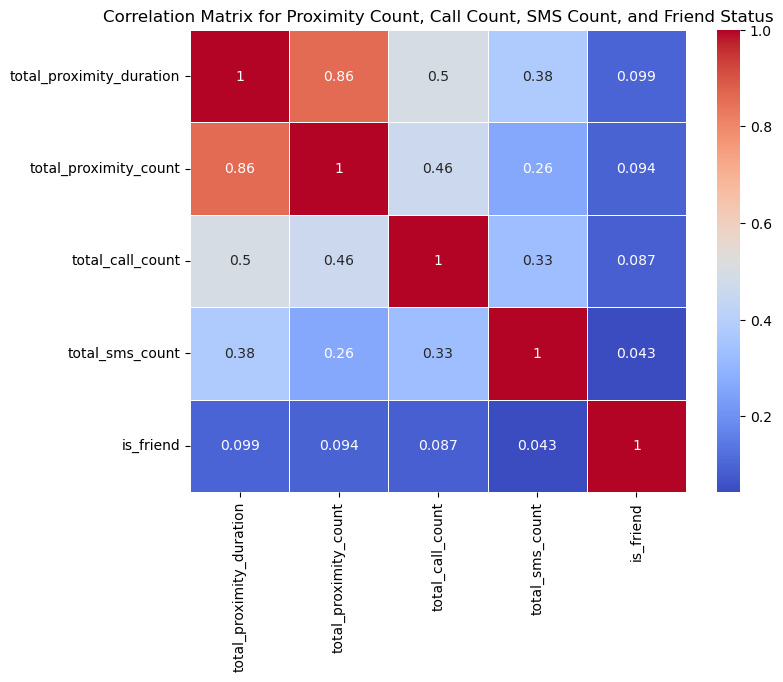

In [136]:
# 选择需要计算相关性的列
correlation_columns = ['total_proximity_duration', 'total_proximity_count', 'total_call_count', 'total_sms_count', 'is_friend']

# 创建一个新的数据框，只保留需要分析的列
correlation_data = merged_summary[correlation_columns].copy()  # 创建副本

# 处理缺失值，例如将 NaN 填充为 0
correlation_data.fillna(0, inplace=True)

# 计算相关性矩阵
correlation_matrix = correlation_data.corr()

# 打印相关性矩阵
print(correlation_matrix)

# 可视化相关性矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Proximity Count, Call Count, SMS Count, and Friend Status')
plt.show()

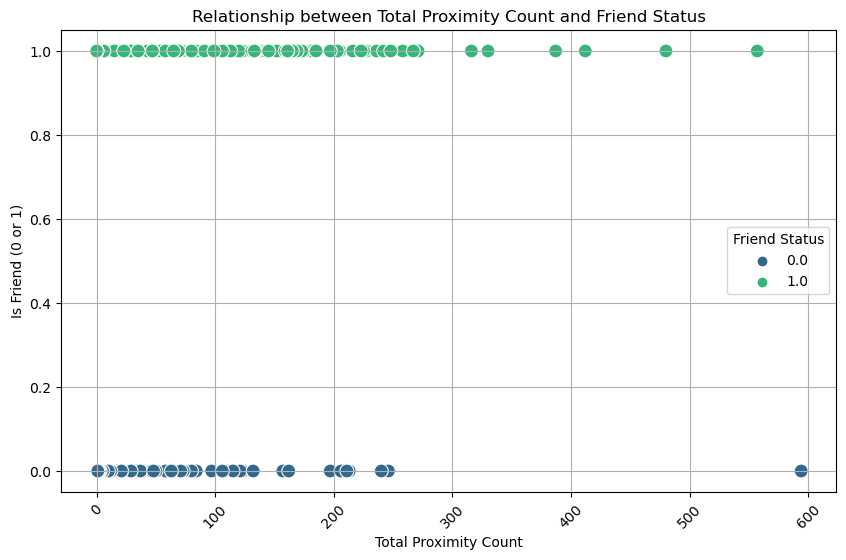

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 seaborn 绘制散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_proximity_count', y='is_friend', hue='is_friend', data=merged_summary, palette='viridis', s=100)
plt.title('Relationship between Total Proximity Count and Friend Status')
plt.xlabel('Total Proximity Count')
plt.ylabel('Is Friend (0 or 1)')
plt.xticks(rotation=45)  # 如果 x 轴标签较密集，可以考虑旋转
plt.grid(True)  # 添加网格线以便更易读
plt.legend(title='Friend Status')  # 添加图例标题
plt.show()

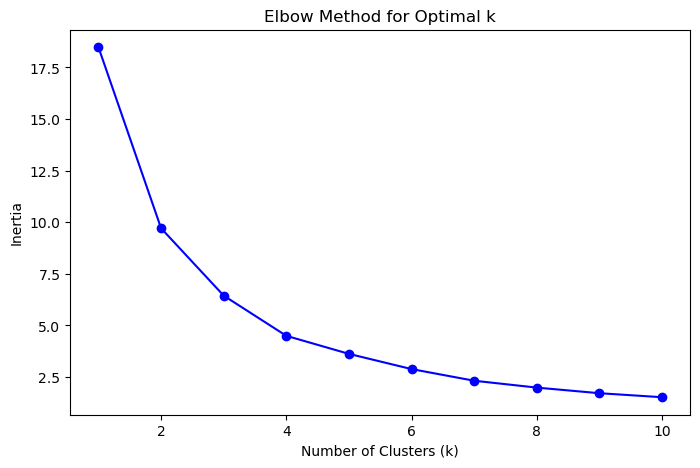

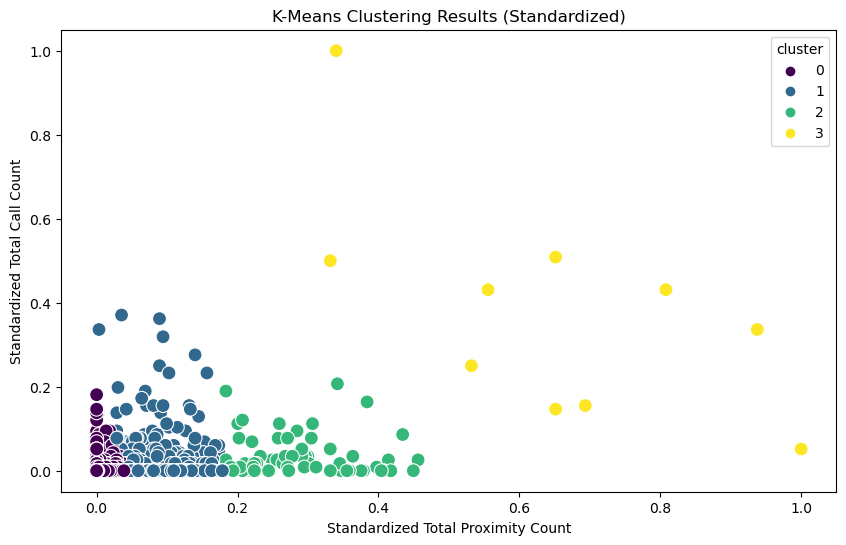

In [124]:
features = merged_summary[['total_proximity_count', 'total_call_count']].copy()  # 使用 copy() 创建副本

# 处理缺失值
features.fillna(0, inplace=True)  # 填充缺失值为 0

# 标准化数据
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# 使用肘部法则选择聚类数量
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # 显式设置 n_init
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# 选择合适的 k（假设为 3）
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)  # 显式设置 n_init
kmeans.fit(scaled_features)

# 将聚类结果添加到原始数据框
merged_summary['cluster'] = kmeans.labels_

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=merged_summary['cluster'], palette='viridis', s=100)
plt.title('K-Means Clustering Results (Standardized)')
plt.xlabel('Standardized Total Proximity Count')
plt.ylabel('Standardized Total Call Count')
plt.show()

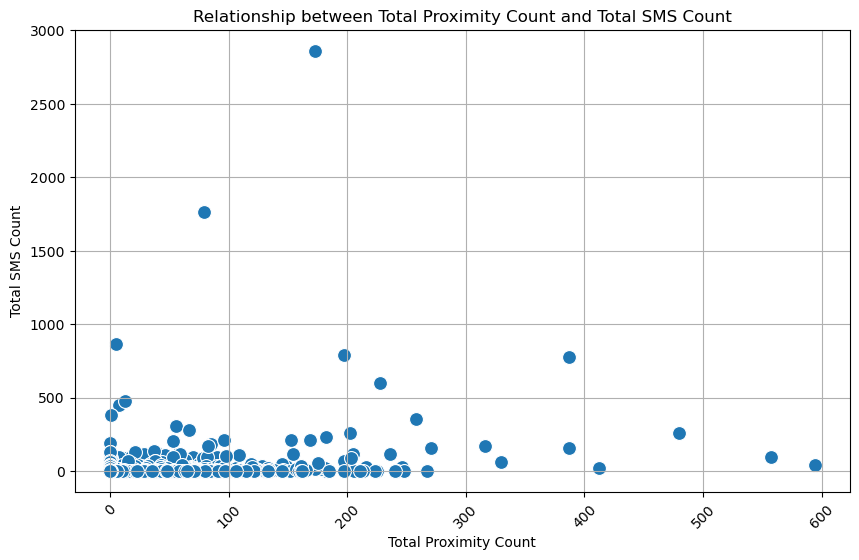

In [126]:
# 创建散点图，展示 total_proximity_count 和 total_sms_count 的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_proximity_count', y='total_sms_count', data=merged_summary, s=100)
plt.title('Relationship between Total Proximity Count and Total SMS Count')
plt.xlabel('Total Proximity Count')
plt.ylabel('Total SMS Count')
plt.xticks(rotation=45)  # 如果 x 轴标签较密集，可以考虑旋转
plt.grid(True)  # 添加网格线以便更易读
plt.show()

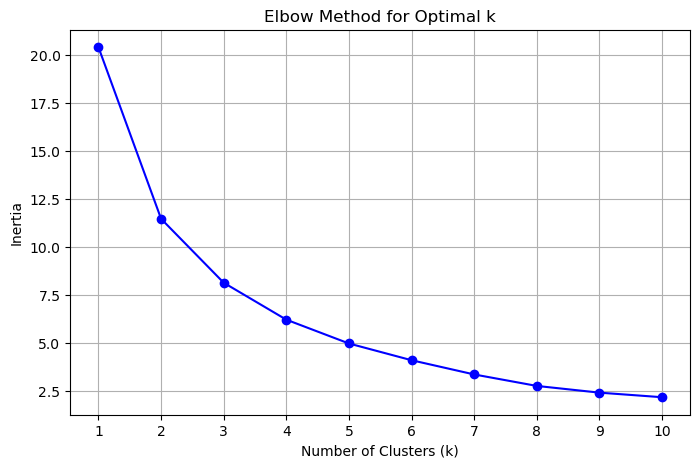

In [130]:
# 假设 merged_summary 是你的合并数据框
# 选择用于聚类的特征
features = merged_summary[['total_proximity_count', 'total_call_count', 'total_sms_count']].copy()  # 使用 copy() 创建副本

# 处理缺失值
features.fillna(0, inplace=True)  # 填充缺失值为 0

# 标准化数据
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

inertia = []
K = range(1, 11)  # 聚类数从1到10
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()


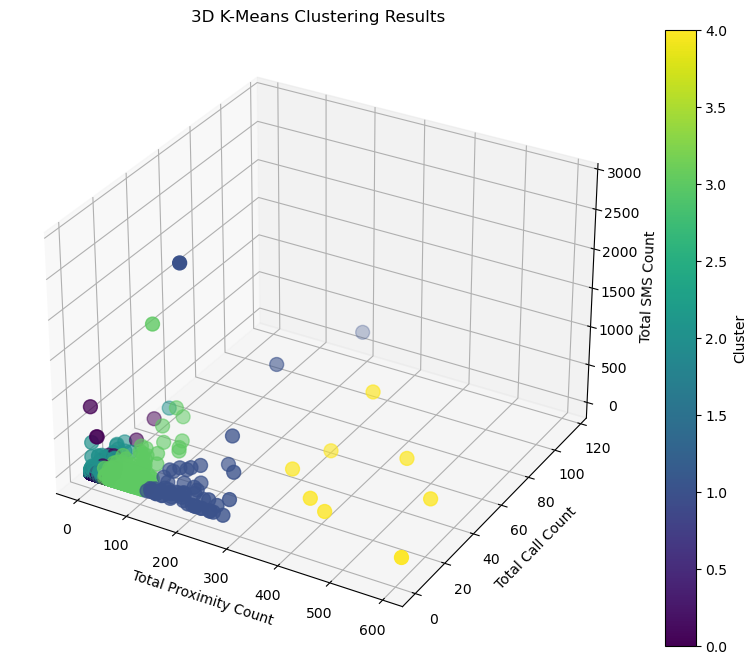

In [141]:
# 使用 K-Means 进行聚类
optimal_k = 5  # 假设你选择的聚类数为 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(scaled_features)

# 将聚类结果添加到原始数据框
merged_summary['cluster'] = kmeans.labels_

# 创建 3D 散点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用不同颜色表示不同聚类
sc = ax.scatter(
    merged_summary['total_proximity_count'],
    merged_summary['total_call_count'],
    merged_summary['total_sms_count'],
    c=merged_summary['cluster'],  # 根据聚类结果上色
    cmap='viridis',
    s=100
)

# 设置轴标签
ax.set_xlabel('Total Proximity Count')
ax.set_ylabel('Total Call Count')
ax.set_zlabel('Total SMS Count')
plt.title('3D K-Means Clustering Results')

# 添加颜色条
cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

plt.show()

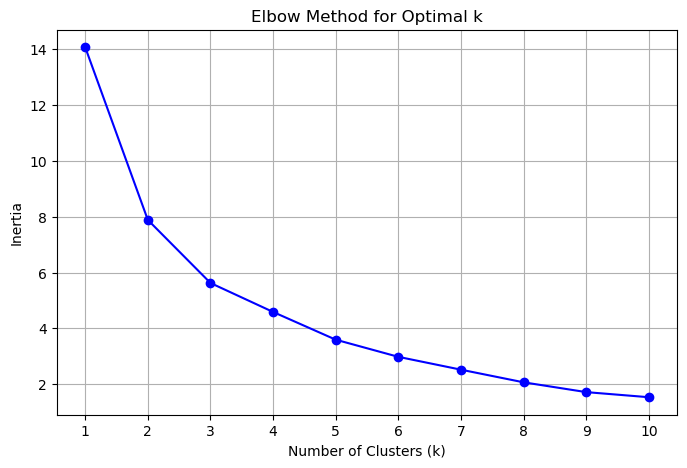

In [171]:
# 假设 merged_summary 是你的合并数据框
# 选择用于聚类的特征
features = merged_summary[['total_proximity_duration', 'total_call_count', 'total_sms_count']].copy()  # 使用 copy() 创建副本

# 处理缺失值
features.fillna(0, inplace=True)  # 填充缺失值为 0

# 标准化数据
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

inertia = []
K = range(1, 11)  # 聚类数从1到10
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

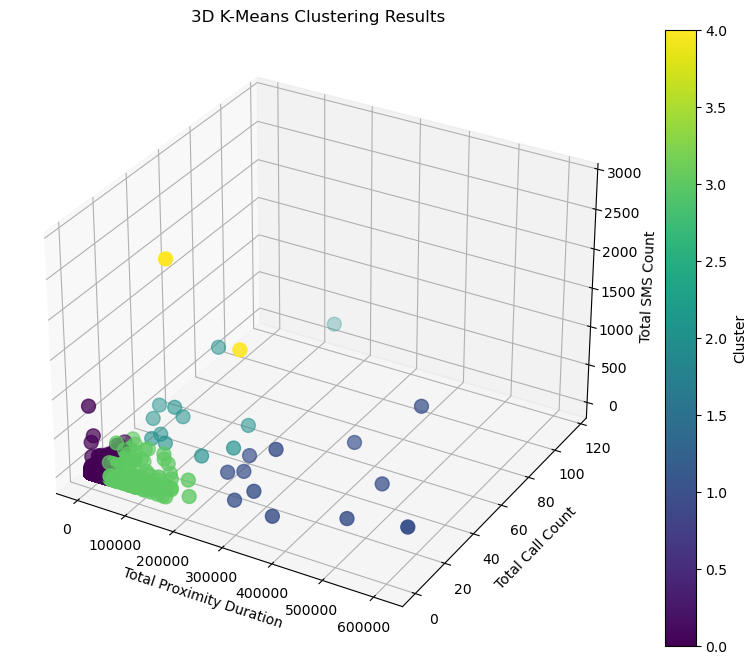

In [172]:
# 使用 K-Means 进行聚类
optimal_k = 5  # 假设你选择的聚类数为 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(scaled_features)

# 将聚类结果添加到原始数据框
merged_summary['cluster'] = kmeans.labels_

# 创建 3D 散点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用不同颜色表示不同聚类
sc = ax.scatter(
    merged_summary['total_proximity_duration'],
    merged_summary['total_call_count'],
    merged_summary['total_sms_count'],
    c=merged_summary['cluster'],  # 根据聚类结果上色
    cmap='viridis',
    s=100
)

# 设置轴标签
ax.set_xlabel('Total Proximity Duration')
ax.set_ylabel('Total Call Count')
ax.set_zlabel('Total SMS Count')
plt.title('3D K-Means Clustering Results')

# 添加颜色条
cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

plt.show()

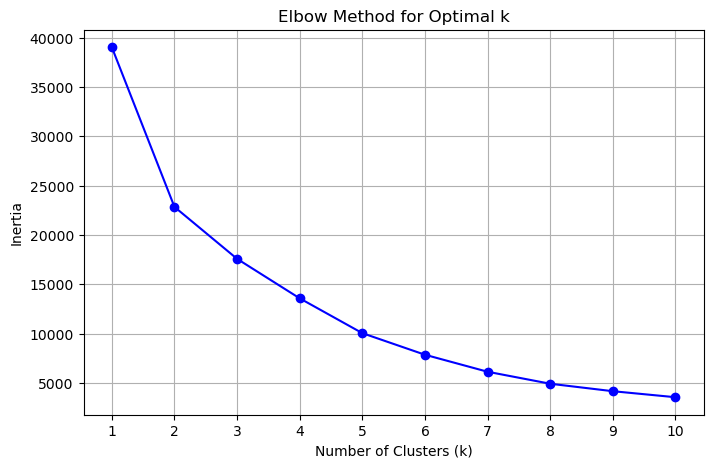

In [187]:
# 假设 merged_summary 是你的合并数据框
# 选择用于聚类的特征
features = merged_summary[['total_proximity_duration', 'total_call_count', 'is_friend']].copy()  # 使用 copy() 创建副本

# 处理缺失值
features.fillna(0, inplace=True)  # 填充缺失值为 0

# 标准化数据
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['total_proximity_duration', 'total_call_count']])
scaled_features = pd.DataFrame(scaled_features, columns=['total_proximity_duration', 'total_call_count'])
scaled_features['is_friend'] = features['is_friend'].values

inertia = []
K = range(1, 11)  # 聚类数从1到10
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

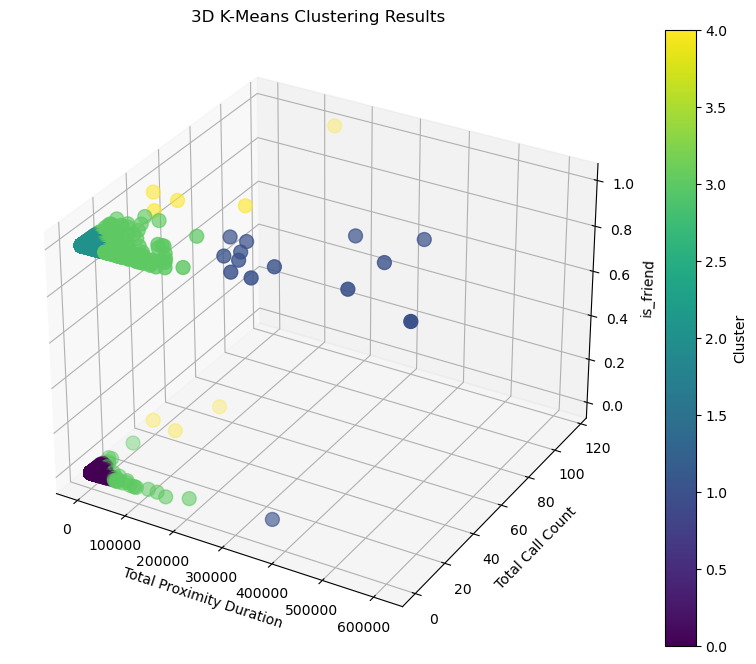

In [188]:
# 使用 K-Means 进行聚类
optimal_k = 5  # 假设你选择的聚类数为 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(scaled_features)

# 将聚类结果添加到原始数据框
merged_summary['cluster'] = kmeans.labels_

# 创建 3D 散点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用不同颜色表示不同聚类
sc = ax.scatter(
    merged_summary['total_proximity_duration'],
    merged_summary['total_call_count'],
    merged_summary['is_friend'],
    c=merged_summary['cluster'],  # 根据聚类结果上色
    cmap='viridis',
    s=100
)

# 设置轴标签
ax.set_xlabel('Total Proximity Duration')
ax.set_ylabel('Total Call Count')
ax.set_zlabel('is_friend')
plt.title('3D K-Means Clustering Results')

# 添加颜色条
cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

plt.savefig('3D_K-Means_Clustering_Results.png')
plt.show()

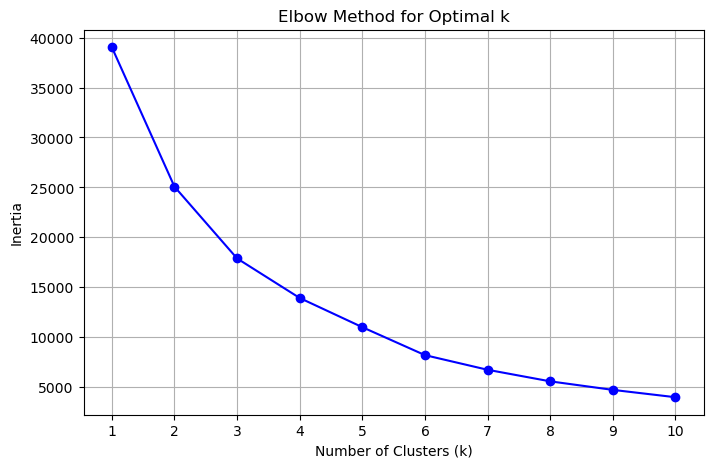

In [185]:
# 假设 merged_summary 是你的合并数据框
# 选择用于聚类的特征
features = merged_summary[['total_proximity_count', 'total_call_count', 'is_friend']].copy()  # 使用 copy() 创建副本

# 处理缺失值
features.fillna(0, inplace=True)  # 填充缺失值为 0

# 标准化数据
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['total_proximity_count', 'total_call_count']])
scaled_features = pd.DataFrame(scaled_features, columns=['total_proximity_count', 'total_call_count'])
scaled_features['is_friend'] = features['is_friend'].values

inertia = []
K = range(1, 11)  # 聚类数从1到10
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

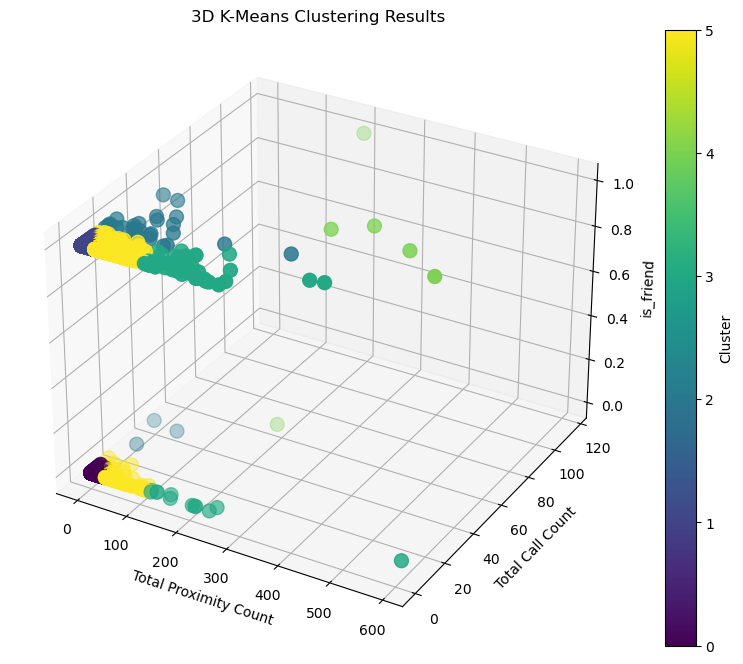

In [186]:
# 使用 K-Means 进行聚类
optimal_k = 6  # 假设你选择的聚类数为 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(scaled_features)

# 将聚类结果添加到原始数据框
merged_summary['cluster'] = kmeans.labels_

# 创建 3D 散点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用不同颜色表示不同聚类
sc = ax.scatter(
    merged_summary['total_proximity_count'],
    merged_summary['total_call_count'],
    merged_summary['is_friend'],
    c=merged_summary['cluster'],  # 根据聚类结果上色
    cmap='viridis',
    s=100
)

# 设置轴标签
ax.set_xlabel('Total Proximity Count')
ax.set_ylabel('Total Call Count')
ax.set_zlabel('is_friend')
plt.title('3D K-Means Clustering Results')

# 添加颜色条
cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

plt.show()

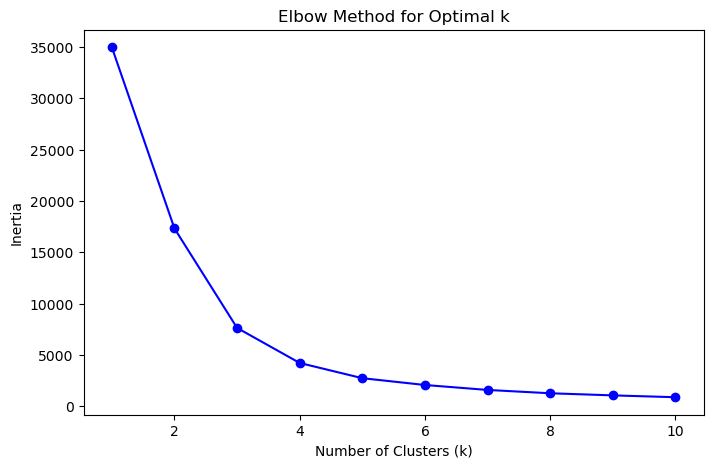

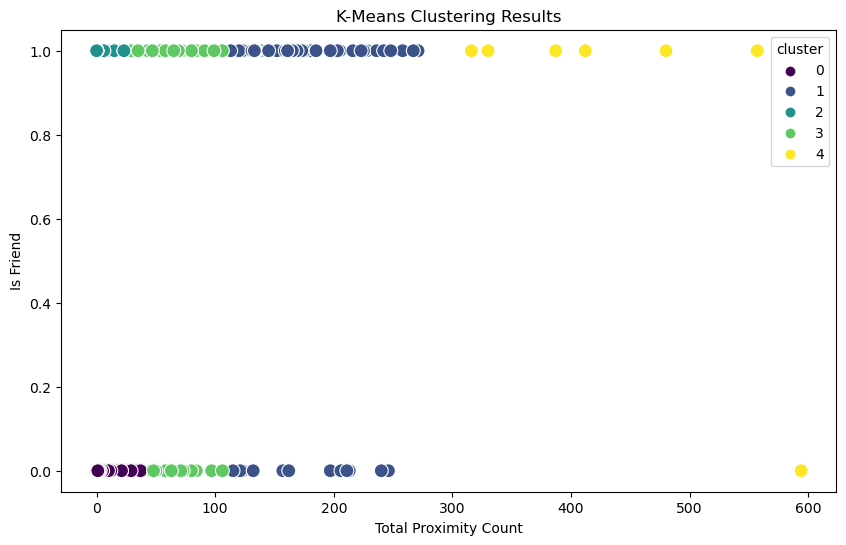

In [162]:
# 假设 merged_summary 是你的合并数据框
# 选择用于聚类的特征
features = merged_summary[['total_proximity_count', 'is_friend']].copy()  # 使用 copy() 创建副本

# 处理缺失值
features.fillna(0, inplace=True)  # 处理缺失值

# 标准化数据
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 使用肘部法则选择聚类数量
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # 显式设置 n_init
    kmeans.fit(scaled_features)  # 使用原始特征数据
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# 使用 K-Means 进行聚类
optimal_k = 5  # 假设你选择的聚类数为 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(scaled_features)  # 使用原始特征数据

# 将聚类结果添加到原始数据框
merged_summary['cluster'] = kmeans.labels_

# 使用原始数据进行可视化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_proximity_count', y='is_friend', hue=merged_summary['cluster'], palette='viridis', s=100, data=merged_summary)
plt.title('K-Means Clustering Results')
plt.xlabel('Total Proximity Count')
plt.ylabel('Is Friend')
plt.show()


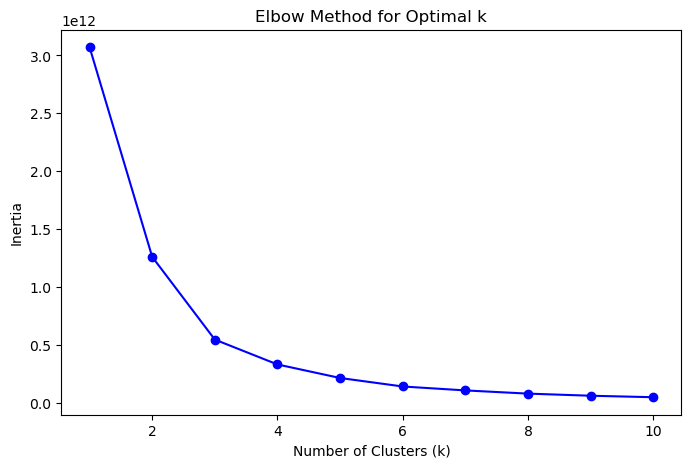

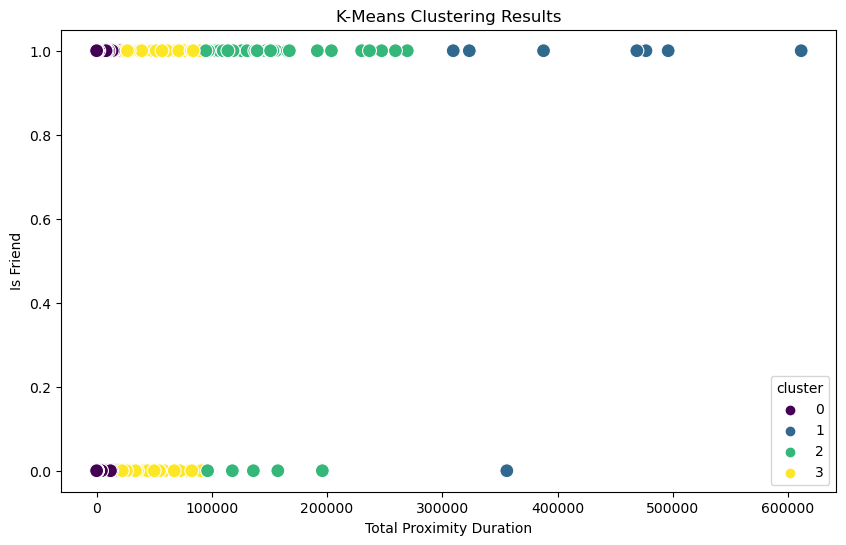

In [184]:
# 假设 merged_summary 是你的合并数据框
# 选择用于聚类的特征
features = merged_summary[['total_proximity_duration', 'is_friend']].copy()  # 使用 copy() 创建副本

# 处理缺失值
features.fillna(0, inplace=True)  # 处理缺失值

# # 标准化数据
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# 使用肘部法则选择聚类数量
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # 显式设置 n_init
    kmeans.fit(features)  # 使用原始特征数据
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# 使用 K-Means 进行聚类
optimal_k = 4  # 假设你选择的聚类数为 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(features)  # 使用原始特征数据

# 将聚类结果添加到原始数据框
merged_summary['cluster'] = kmeans.labels_

# 使用原始数据进行可视化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_proximity_duration', y='is_friend', hue=merged_summary['cluster'], palette='viridis', s=100, data=merged_summary)
plt.title('K-Means Clustering Results')
plt.xlabel('Total Proximity Duration')
plt.ylabel('Is Friend')
plt.show()

In [142]:
friends_only = merged_summary[merged_summary['is_friend'] == 1]

friends_only

,user_a,user_b,total_sms_count,total_call_count,total_call_duration,total_proximity_count,total_proximity_duration,is_friend,cluster
0,13,11,2.0,1.0,2.0,7.0,915.0,1.0,2
1,13,12,31.0,3.0,58.0,148.0,45537.5,1.0,1
3,25,12,2.0,1.0,29.0,70.0,38785.0,1.0,3
4,27,6,69.0,6.0,115.0,197.0,103745.0,1.0,1
5,37,36,203.0,29.0,4955.0,53.0,203740.0,1.0,3
...,...,...,...,...,...,...,...,...,...
17484,715,510,0.0,0.0,0.0,0.0,0.0,1.0,2
17485,737,510,0.0,0.0,0.0,0.0,0.0,1.0,2
17486,763,510,0.0,0.0,0.0,0.0,0.0,1.0,2
17487,605,255,0.0,0.0,0.0,0.0,0.0,1.0,2


In [143]:
friends_not = merged_summary[merged_summary['is_friend'] == 0]

friends_not

,user_a,user_b,total_sms_count,total_call_count,total_call_duration,total_proximity_count,total_proximity_duration,is_friend,cluster
2,21,20,788.0,58.0,1962.0,197.0,80057.5,0.0,1
17,82,24,17.0,2.0,280.0,0.0,0.0,0.0,0
27,119,95,1.0,0.0,0.0,24.0,7527.5,0.0,0
33,137,25,1.0,0.0,0.0,5.0,1802.5,0.0,0
39,149,72,3.0,0.0,0.0,206.0,92385.0,0.0,1
...,...,...,...,...,...,...,...,...,...
13356,812,423,0.0,0.0,0.0,2.0,602.5,0.0,0
13358,812,448,0.0,0.0,0.0,1.0,2.5,0.0,0
13360,812,637,0.0,0.0,0.0,2.0,602.5,0.0,0
13361,812,662,0.0,0.0,0.0,1.0,2.5,0.0,0


In [ ]:
#  Also consider DBSCAN, Hierarchical Clustering

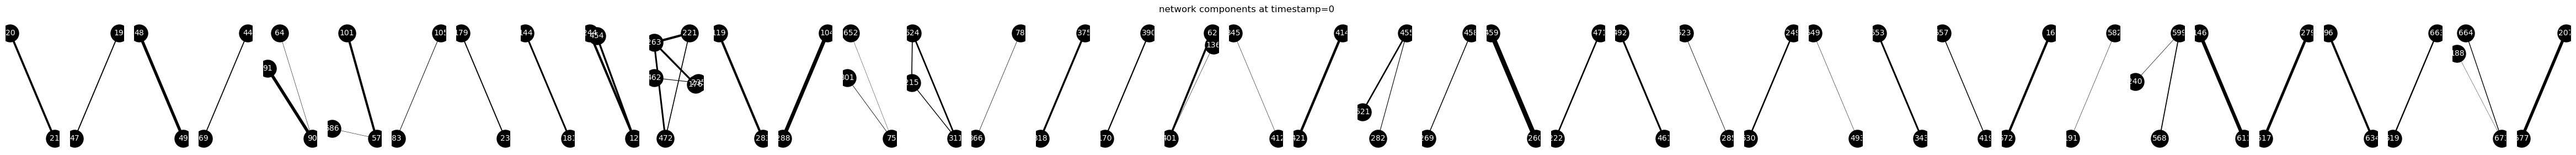

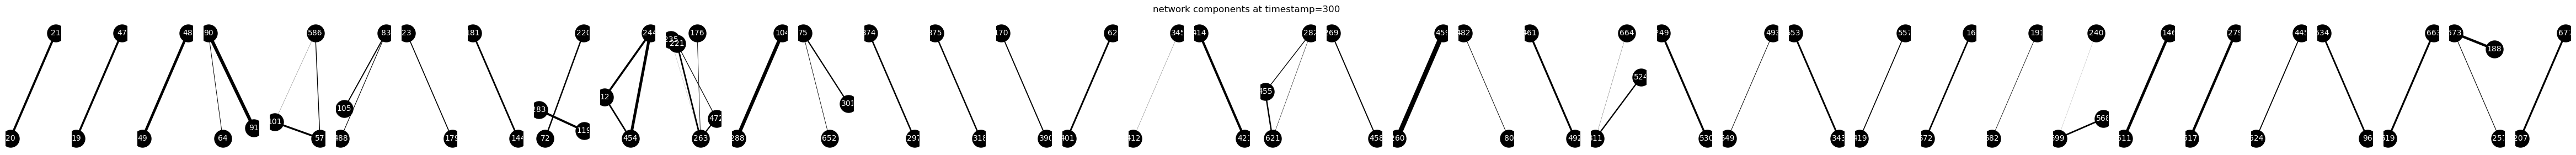

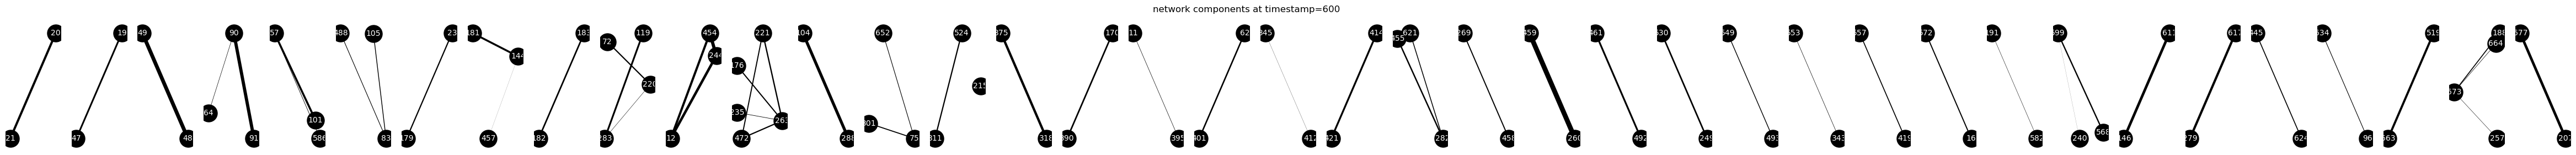

In [25]:
def VisualizeBluetoothNetwork(df_bt, timestamp):
  """ Plots each connected component in |df_bt| network at |timestamp|."""
  # NetworkX graph to plot the results.
  G = nx.Graph()

  # In-study users (id >= 0) at given timestamp.
  in_study_users_at_timestamp = df_bt[(df_bt["# timestamp"] == timestamp)
                                      & (df_bt["user_b"] >= 0)][[
                                          "user_a", "user_b", "rssi"
                                      ]]

  # Builds an undirected network of the in-study users.
  for row in in_study_users_at_timestamp.itertuples():
    user_a = row[1]
    user_b = row[2]
    rssi = row[3]
    G.add_edge(user_a, user_b, weight=rssi)

  # For clarity, we consier each connected component separately.  
  connected_components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
  fig, axs = plt.subplots(1, len(connected_components), figsize=(60, 3))


  
  # Plots the connected components of the network.
  fig.suptitle("network components at timestamp={}".format(timestamp))
  [
      nx.draw(
          connected_component,
          # Positions of nodes are calculatued using spring layout.
          pos=nx.spring_layout(connected_component, scale=0.2),
          ax=axs[i],
          # Width of the edges is based on higher RSSI = stronger edge.
          width=[(100 + connected_component[u][v]["weight"]) / 10.0
                 for u, v in connected_component.edges()],
          node_size=500,
          node_color="black",
          with_labels=True,
          font_size=10,
          font_color="white")
      for i, connected_component in enumerate(connected_components)
  ]


VisualizeBluetoothNetwork(df_bt, 0)
VisualizeBluetoothNetwork(df_bt, 300)
VisualizeBluetoothNetwork(df_bt, 600)

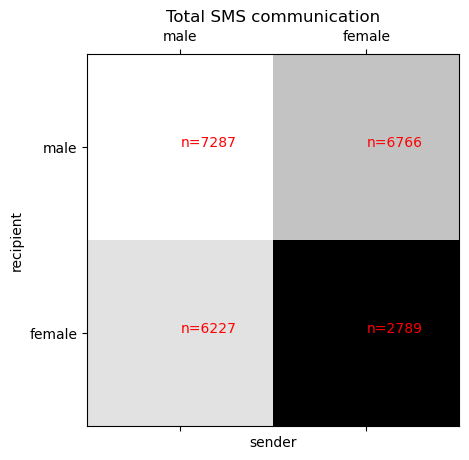

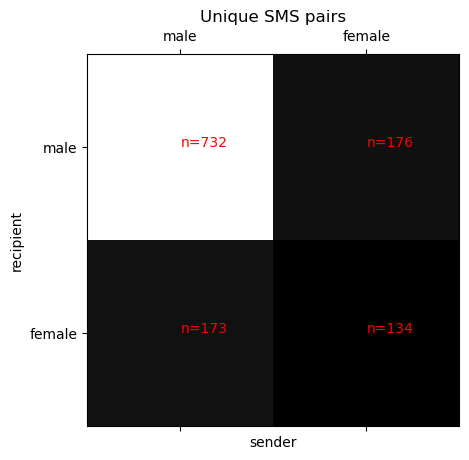

In [6]:
def VisualizeTextMessages(df_sms, df_genders):
  """Plots the SMS communication by gender of senders and recipients."""

  # Creates SMS network including gender of the senders.
  df_sms_with_gender_sender = pd.merge(
      df_sms, df_genders, left_on="sender", right_on="# user").rename(
          index=str, columns={
              "female": "female_sender"
          }).drop(
              "# user", axis=1)

  # Creates SMS network including gender of the recipients.
  df_sms_with_gender = pd.merge(
      df_sms_with_gender_sender,
      df_genders,
      left_on="recipient",
      right_on="# user").rename(
          index=str, columns={
              "female": "female_recipient"
          }).drop(
              "# user", axis=1)

  # Computes total communication (all messages) and number of unique pairs based
  # on sender and recipient gender.
  totals = np.zeros((2, 2))
  unique_pairs = np.zeros((2, 2))
  for female_sender in [0, 1]:
    for female_recipient in [0, 1]:
      totals[female_sender, female_recipient] = df_sms_with_gender[
          (df_sms_with_gender["female_sender"] == female_sender)
          &
          (df_sms_with_gender["female_recipient"] == female_recipient)].shape[0]
      unique_pairs[female_sender, female_recipient] = df_sms_with_gender[
          (df_sms_with_gender["female_sender"] == female_sender)
          & (df_sms_with_gender["female_recipient"] == female_recipient)][[
              "sender", "recipient"
          ]].drop_duplicates().shape[0]

  # Plots the breakdowns.
  plt.matshow(totals, cmap=plt.cm.gray)
  plt.grid(False)
  plt.xlabel("sender")
  plt.ylabel("recipient")
  plt.xticks([0, 1], ["male", "female"])
  plt.yticks([0, 1], ["male", "female"])
  [
      plt.text(
          sender,
          recipient,
          "n={}".format(int(totals[sender][recipient])),
          color="red")
      for sender, recipient in itertools.product([0, 1], [0, 1])
  ]
  plt.title("Total SMS communication")

  plt.matshow(unique_pairs, cmap=plt.cm.gray)
  plt.grid(False)
  plt.xlabel("sender")
  plt.ylabel("recipient")
  plt.xticks([0, 1], ["male", "female"])
  plt.yticks([0, 1], ["male", "female"])
  [
      plt.text(
          sender,
          recipient,
          "n={}".format(int(unique_pairs[sender][recipient])),
          color="red")
      for sender, recipient in itertools.product([0, 1], [0, 1])
  ]
  plt.title("Unique SMS pairs")


VisualizeTextMessages(df_sms, df_genders)